In [1]:
import tensorflow as tf
import numpy as np
from censai import PhysicalModel, RIMUnet, RayTracer
from censai.models import UnetModel
from censai.data.lenses_tng import decode_train, decode_physical_model_info
from censai.utils import nullwriter, rim_residual_plot as residual_plot, plot_to_image
import os, glob, time
from tensorboard.plugins.hparams import api as hp
from datetime import datetime
import random
""" # NOTE ON THE USE OF MULTIPLE GPUS #
Double the number of gpus will not speed up the code. In fact, doubling the number of gpus and mirroring 
the ops accross replicas means the code is TWICE as slow.

In fact, using multiple gpus means one should at least multiply the batch size by the number of gpus introduced, 
and optimize hyperparameters accordingly (learning rate should be scaled similarly).
"""
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) == 1:
    STRATEGY = tf.distribute.OneDeviceStrategy(device="/gpu:0")
elif len(gpus) > 1:
    STRATEGY = tf.distribute.MirroredStrategy()



RIM_HPARAMS = [
    "adam",
    "steps",
    "kappalog",
    "kappa_normalize"
]
SOURCE_MODEL_HPARAMS = [
    "filters",
    "filter_scaling",
    "kernel_size",
    "layers",
    "block_conv_layers",
    "strides",
    "bottleneck_kernel_size",
    "bottleneck_filters",
    "resampling_kernel_size",
    "gru_kernel_size",
    "upsampling_interpolation",
    "kernel_regularizer_amp",
    "bias_regularizer_amp",
    "activation",
    "alpha",
    "initializer"
]
KAPPA_MODEL_HPARAMS = [
    "filters",
    "filter_scaling",
    "kernel_size",
    "layers",
    "block_conv_layers",
    "strides",
    "bottleneck_kernel_size",
    "bottleneck_filters",
    "resampling_kernel_size",
    "gru_kernel_size",
    "upsampling_interpolation",
    "kernel_regularizer_amp",
    "bias_regularizer_amp",
    "activation",
    "alpha",
    "initializer"
]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/aadam/environments/censai3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-2a61faa57bf9>", line 1, in <module>
    import tensorflow as tf
  File "/home/aadam/environments/censai3.8/lib/python3.8/site-packages/tensorflow/__init__.py", line 41, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "/home/aadam/environments/censai3.8/lib/python3.8/site-packages/tensorflow/python/__init__.py", line 48, in <module>
    from tensorflow.python import keras
  File "/home/aadam/environments/censai3.8/lib/python3.8/site-packages/tensorflow/python/keras/__init__.py", line 27, in <module>
    from tensorflow.python.keras import models
  File "/home/aadam/environments/censai3.8/lib/python3.8/site-packages/tensorflow/python/keras/models.py", line 23, in <module>
    from tensorflow.python.keras import

TypeError: object of type 'NoneType' has no len()

In [ ]:
def main(args):
    files = []
    for dataset in args.datasets:
        files.extend(glob.glob(os.path.join(dataset, "*.tfrecords")))
    np.random.shuffle(files)
    # Read concurrently from multiple records
    files = tf.data.Dataset.from_tensor_slices(files)
    dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type=args.compression_type),
                                block_length=args.block_length, num_parallel_calls=tf.data.AUTOTUNE)
    # Read off global parameters from first example in dataset
    for physical_params in dataset.map(decode_physical_model_info):
        break
    dataset = dataset.map(decode_train).batch(args.batch_size)
    if args.cache_file is not None:
        dataset = dataset.cache(args.cache_file).prefetch(tf.data.experimental.AUTOTUNE)
    else:  # do not cache if no file is provided, dataset is huge and does not fit in GPU or RAM
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    train_dataset = dataset.take(int(args.train_split * args.total_items) // args.batch_size) # dont forget to divide by batch size!
    val_dataset = dataset.skip(int(args.train_split * args.total_items) // args.batch_size)
    val_dataset = val_dataset.take(int((1 - args.train_split) * args.total_items) // args.batch_size)
    train_dataset = STRATEGY.experimental_distribute_dataset(train_dataset)
    val_dataset = STRATEGY.experimental_distribute_dataset(val_dataset)
    if args.raytracer is not None:
        with open(os.path.join(args.raytracer, "ray_tracer_hparams.json"), "r") as f:
            raytracer_hparams = json.load(f)
    with STRATEGY.scope():  # Replicate ops accross gpus
        if args.raytracer is not None:
            raytracer = RayTracer(**raytracer_hparams)
            # load last checkpoint in the checkpoint directory
            checkpoint = tf.train.Checkpoint(net=raytracer)
            manager = tf.train.CheckpointManager(checkpoint, directory=args.raytracer, max_to_keep=3)
            checkpoint.restore(manager.latest_checkpoint).expect_partial()
        else:
            raytracer = None
        phys = PhysicalModel(
            pixels=physical_params["kappa pixels"].numpy(),
            src_pixels=physical_params["src pixels"].numpy(),
            image_fov=physical_params["image fov"].numpy(),
            kappa_fov=physical_params["kappa fov"].numpy(),
            src_fov=physical_params["source fov"].numpy(),
            method=args.forward_method,
            noise_rms=physical_params["noise rms"].numpy(),
            raytracer=raytracer
        )
        kappa_model = UnetModel(
            filters=args.kappa_filters,
            filter_scaling=args.kappa_filter_scaling,
            kernel_size=args.kappa_kernel_size,
            layers=args.kappa_layers,
            block_conv_layers=args.kappa_block_conv_layers,
            strides=args.kappa_strides,
            bottleneck_kernel_size=args.kappa_bottleneck_kernel_size,
            bottleneck_filters=args.kappa_bottleneck_filters,
            resampling_kernel_size=args.kappa_resampling_kernel_size,
            gru_kernel_size=args.kappa_gru_kernel_size,
            upsampling_interpolation=args.kappa_upsampling_interpolation,
            kernel_regularizer_amp=args.kappa_kernel_regularizer_amp,
            bias_regularizer_amp=args.kappa_bias_regularizer_amp,
            activation=args.kappa_activation,
            alpha=args.kappa_alpha,  # for leaky relu
            initializer=args.kappa_initializer,
        )
        source_model = UnetModel(
            filters=args.source_filters,
            filter_scaling=args.source_filter_scaling,
            kernel_size=args.source_kernel_size,
            layers=args.source_layers,
            block_conv_layers=args.source_block_conv_layers,
            strides=args.source_strides,
            bottleneck_kernel_size=args.source_bottleneck_kernel_size,
            bottleneck_filters=args.source_bottleneck_filters,
            resampling_kernel_size=args.source_resampling_kernel_size,
            gru_kernel_size=args.source_gru_kernel_size,
            upsampling_interpolation=args.source_upsampling_interpolation,
            kernel_regularizer_amp=args.source_kernel_regularizer_amp,
            bias_regularizer_amp=args.source_bias_regularizer_amp,
            activation=args.source_activation,
            alpha=args.source_alpha,  # for leaky relu
            initializer=args.source_initializer,
        )
        rim = RIMUnet(
            physical_model=phys,
            source_model=source_model,
            kappa_model=kappa_model,
            steps=args.steps,
            adam=args.adam,
            kappalog=args.kappalog,
            source_link=args.source_link,
            kappa_normalize=args.kappa_normalize,
            kappa_init=args.kappa_init,
            source_init=args.source_init
        )
        learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=args.initial_learning_rate,
            decay_rate=args.decay_rate,
            decay_steps=args.decay_steps,
            staircase=args.staircase
        )
        optim = tf.keras.optimizers.deserialize(
            {
                "class_name": args.optimizer,
                'config': {"learning_rate": learning_rate_schedule}
            }
        )

    # ==== Take care of where to write logs and stuff =================================================================
    if args.model_id.lower() != "none":
        logname = args.model_id
    elif args.logname is not None:
        logname = args.logname
    else:
        logname = args.logname_prefixe + datetime.now().strftime("%y-%m-%d_%H-%M-%S")
    if args.logdir.lower() != "none":
        logdir = os.path.join(args.logdir, logname)
        if not os.path.isdir(logdir):
            os.mkdir(logdir)
        writer = tf.summary.create_file_writer(logdir)
    else:
        writer = nullwriter()
    # ===== Make sure directory and checkpoint manager are created to save model ===================================
    if args.model_dir.lower() != "none":
        models_dir = os.path.join(args.model_dir, logname)
        if not os.path.isdir(models_dir):
            os.mkdir(models_dir)
            with open(os.path.join(models_dir, "script_params.json"), "w") as f:
                json.dump(vars(args), f, indent=4)
        source_checkpoints_dir = os.path.join(models_dir, "source_checkpoints")
        if not os.path.isdir(source_checkpoints_dir):
            os.mkdir(source_checkpoints_dir)
            with open(os.path.join(source_checkpoints_dir, "hparams.json"), "w") as f:
                hparams_dict = {key: vars(args)["source_" + key] for key in SOURCE_MODEL_HPARAMS}
                json.dump(hparams_dict, f, indent=4)
        kappa_checkpoints_dir = os.path.join(models_dir, "kappa_checkpoints")
        if not os.path.isdir(kappa_checkpoints_dir):
            os.mkdir(kappa_checkpoints_dir)
            with open(os.path.join(kappa_checkpoints_dir, "hparams.json"), "w") as f:
                hparams_dict = {key: vars(args)["kappa_" + key] for key in KAPPA_MODEL_HPARAMS}
                json.dump(hparams_dict, f, indent=4)
        source_ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optim, net=rim.source_model)
        source_checkpoint_manager = tf.train.CheckpointManager(source_ckpt, source_checkpoints_dir, max_to_keep=args.max_to_keep)
        kappa_ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optim, net=rim.kappa_model)
        kappa_checkpoint_manager = tf.train.CheckpointManager(kappa_ckpt, kappa_checkpoints_dir, max_to_keep=args.max_to_keep)
        save_checkpoint = True
        # ======= Load model if model_id is provided ===============================================================
        if args.model_id.lower() != "none":
            if args.load_checkpoint == "lastest":
                kappa_checkpoint_manager.checkpoint.restore(kappa_checkpoint_manager.latest_checkpoint)
                source_checkpoint_manager.checkpoint.restore(source_checkpoint_manager.latest_checkpoint)
            elif args.load_checkpoint == "best":
                kappa_scores = np.loadtxt(os.path.join(kappa_checkpoints_dir, "score_sheet.txt"))
                source_scores = np.loadtxt(os.path.join(source_checkpoints_dir, "score_sheet.txt"))
                _kappa_checkpoint = kappa_scores[np.argmin(kappa_scores[:, 1]), 0]
                _source_checkpoint = source_scores[np.argmin(source_scores[:, 1]), 0]
                kappa_checkpoint = kappa_checkpoint_manager.checkpoints[_kappa_checkpoint]
                kappa_checkpoint_manager.checkpoint.restore(kappa_checkpoint)
                source_checkpoint = kappa_checkpoint_manager.checkpoints[_source_checkpoint]
                source_checkpoint_manager.checkpoint.restore(source_checkpoint)
            else:
                kappa_checkpoint = kappa_checkpoint_manager.checkpoints[int(args.load_checkpoint)]
                source_checkpoint = source_checkpoint_manager.checkpoints[int(args.load_checkpoint)]
                kappa_checkpoint_manager.checkpoint.restore(kappa_checkpoint)
                source_checkpoint_manager.checkpoint.restore(source_checkpoint)
    else:
        save_checkpoint = False
    # =================================================================================================================

    def train_step(inputs):
        X, source, kappa = inputs
        with tf.GradientTape(persistent=True, watch_accessed_variables=True) as tape:
            tape.watch(rim.source_model.trainable_variables)
            tape.watch(rim.kappa_model.trainable_variables)
            cost, chi_squared = rim.cost_function(X, source, kappa, outer_tape=tape, reduction=False)
            cost = tf.reduce_sum(cost) / args.batch_size  # Reduce by the global batch size, not the replica batch size
        gradient1 = tape.gradient(cost, rim.source_model.trainable_variables)
        gradient2 = tape.gradient(cost, rim.kappa_model.trainable_variables)
        if args.clipping:
            gradient1 = [tf.clip_by_value(grad, -10, 10) for grad in gradient1]
            gradient2 = [tf.clip_by_value(grad, -10, 10) for grad in gradient2]
        optim.apply_gradients(zip(gradient1, rim.source_model.trainable_variables))
        optim.apply_gradients(zip(gradient2, rim.kappa_model.trainable_variables))
        chi_squared = tf.reduce_sum(chi_squared) / args.batch_size
        return cost, chi_squared

    @tf.function
    def distributed_train_step(dist_inputs):
        per_replica_losses, per_replica_chi_squared = STRATEGY.run(train_step, args=(dist_inputs,))
        # Replica losses are aggregated by summing them
        global_loss = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
        global_chi_squared = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_chi_squared, axis=None)
        return global_loss, global_chi_squared

    def test_step(inputs):
        X, source, kappa = inputs
        cost, chi_squared = rim.cost_function(X, source, kappa, reduction=False)
        cost = tf.reduce_sum(cost) / args.batch_size
        chi_squared = tf.reduce_sum(chi_squared) / args.batch_size
        return cost, chi_squared

    @tf.function
    def distributed_test_step(dist_inputs):
        per_replica_losses, per_replica_chi_squared = STRATEGY.run(test_step, args=(dist_inputs,))
        global_loss = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
        global_chi_squared = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_chi_squared, axis=None)
        return global_loss, global_chi_squared

    # ====== Training loop ============================================================================================
    epoch_loss = tf.metrics.Mean()
    time_per_step = tf.metrics.Mean()
    val_loss = tf.metrics.Mean()
    epoch_chi_squared = tf.metrics.Mean()
    val_chi_squared = tf.metrics.Mean()
    history = {  # recorded at the end of an epoch only
        "train_cost": [],
        "train_chi_squared": [],
        "val_cost": [],
        "val_chi_squared": [],
        "learning_rate": [],
        "time_per_step": []
    }
    best_loss = np.inf
    patience = args.patience
    step = 0
    lastest_checkpoint = 1
    for epoch in range(args.epochs):
        epoch_loss.reset_states()
        epoch_chi_squared.reset_states()
        time_per_step.reset_states()
        with writer.as_default():
            for batch, distributed_inputs in enumerate(train_dataset):
                start = time.time()
                cost, chi_squared = distributed_train_step(distributed_inputs)
        # ========== Summary and logs ==================================================================================
                _time = time.time() - start
                tf.summary.scalar("Time per step", _time, step=step)
                tf.summary.scalar("MSE", cost, step=step)
                tf.summary.scalar("Chi Squared", chi_squared, step=step)
                time_per_step.update_state([_time])
                epoch_loss.update_state([cost])
                epoch_chi_squared.update_state([chi_squared])
                step += 1
            # last batch we make a summary of residuals
            for res_idx in range(min(args.n_residuals, args.batch_size)):
                lens_true = distributed_inputs[0][res_idx, ...]
                source_true = distributed_inputs[1][res_idx, ...]
                kappa_true = distributed_inputs[2][res_idx, ...]
                source_pred, kappa_pred, chi_squared = rim.predict(lens_true[None, ...])
                lens_pred = phys.forward(source_pred[-1], kappa_pred[-1])[0, ...]
                tf.summary.image(f"Residuals {res_idx}",
                                 plot_to_image(
                                     residual_plot(
                                         lens_true, source_true, kappa_true, lens_pred, source_pred[-1][0, ...],
                                         kappa_pred[-1][0, ...], chi_squared[-1][0]
                                     )), step=step)

            # ========== Validation set ===================
            val_loss.reset_states()
            val_chi_squared.reset_states()
            for distributed_inputs in val_dataset:
                cost, chi_squared = distributed_test_step(distributed_inputs)
                val_loss.update_state([cost])
                val_chi_squared.update_state([chi_squared])

            for res_idx in range(min(args.n_residuals, args.batch_size)):
                lens_true = distributed_inputs[0][res_idx, ...]
                source_true = distributed_inputs[1][res_idx, ...]
                kappa_true = distributed_inputs[2][res_idx, ...]
                source_pred, kappa_pred, chi_squared = rim.predict(lens_true[None, ...])
                lens_pred = phys.forward(source_pred[-1], kappa_pred[-1])[0, ...]
                tf.summary.image(f"Val Residuals {res_idx}",
                                 plot_to_image(
                                     residual_plot(
                                         lens_true, source_true, kappa_true, lens_pred, source_pred[-1][0, ...],
                                         kappa_pred[-1][0, ...], chi_squared[-1][0]
                                     )), step=step)
        val_cost = val_loss.result().numpy()
        val_chi_sq = val_chi_squared.result().numpy()
        train_cost = epoch_loss.result().numpy()
        train_chi_sq = epoch_chi_squared.result().numpy()
        tf.summary.scalar("Val MSE", val_cost, step=step)
        tf.summary.scalar("Learning Rate", optim.lr(step), step=step)
        tf.summary.scalar("Val Chi Squared", val_chi_sq, step=step)
        print(f"epoch {epoch} | train loss {train_cost:.3e} | val loss {val_cost:.3e} "
              f"| learning rate {optim.lr(step).numpy():.2e} | time per step {time_per_step.result().numpy():.2e} s")
        history["train_cost"].append(train_cost)
        history["val_cost"].append(val_cost)
        history["learning_rate"].append(optim.lr(step).numpy())
        history["train_chi_squared"].append(train_chi_sq)
        history["val_chi_squared"].append(val_chi_sq)
        history["time_per_step"].append(time_per_step.result().numpy())

        cost = train_cost if args.track_train else val_cost
        if np.isnan(cost):
            print("Training broke the Universe")
            break
        if cost < (1 - args.tolerance) * best_loss:
            best_loss = cost
            patience = args.patience
        else:
            patience -= 1
        if save_checkpoint:
            source_checkpoint_manager.checkpoint.step.assign_add(1) # a bit of a hack
            kappa_checkpoint_manager.checkpoint.step.assign_add(1)
            if epoch % args.checkpoints == 0 or patience == 0 or epoch == args.epochs - 1:
                with open(os.path.join(kappa_checkpoints_dir, "score_sheet.txt"), mode="a") as f:
                    np.savetxt(f, np.array([[lastest_checkpoint, cost]]))
                with open(os.path.join(source_checkpoints_dir, "score_sheet.txt"), mode="a") as f:
                    np.savetxt(f, np.array([[lastest_checkpoint, cost]]))
                lastest_checkpoint += 1
                source_checkpoint_manager.save()
                kappa_checkpoint_manager.save()
                print("Saved checkpoint for step {}: {}".format(int(source_checkpoint_manager.checkpoint.step),
                                                                source_checkpoint_manager.latest_checkpoint))
        if patience == 0:
            print("Reached patience")
            break

    return rim, phys, train_dataset, val_dataset

In [ ]:
from argparse import ArgumentParser
import json
parser = ArgumentParser()
parser.add_argument("--model_id",               default="None",                 help="Start from this model id checkpoint. None means start from scratch")
parser.add_argument("--load_checkpoint",        default="best",                 help="One of 'best', 'lastest' or the specific checkpoint index.")
parser.add_argument("--datasets",               required=True,  nargs="+",      help="Path to directories that contains tfrecords of dataset. Can be multiple inputs (space separated)")
parser.add_argument("--compression_type",       default=None,                   help="Compression type used to write data. Default assumes no compression.")

# RIM hyperparameters
parser.add_argument("--steps",                  default=16,     type=int,       help="Number of time steps of RIM")
parser.add_argument("--adam",                   action="store_true",            help="ADAM update for the log-likelihood gradient.")
parser.add_argument("--kappalog",               action="store_true")
parser.add_argument("--kappa_normalize",        action="store_true")
parser.add_argument("--source_link",            default="identity",             help="One of 'exp', 'source' or 'identity' (default).")
parser.add_argument("--kappa_init",             default=1e-1,   type=float,     help="Initial value of kappa for RIM")
parser.add_argument("--source_init",            default=1e-3,   type=float,     help="Initial value of source for RIM")

# Kappa model hyperparameters
parser.add_argument("--kappa_filters",                  default=32,     type=int)
parser.add_argument("--kappa_filter_scaling",           default=1,      type=int)
parser.add_argument("--kappa_kernel_size",              default=3,      type=int)
parser.add_argument("--kappa_layers",                   default=2,      type=int)
parser.add_argument("--kappa_block_conv_layers",        default=2,      type=int)
parser.add_argument("--kappa_strides",                  default=2,      type=int)
parser.add_argument("--kappa_bottleneck_kernel_size",   default=None,   type=int)
parser.add_argument("--kappa_bottleneck_filters",       default=None,   type=int)
parser.add_argument("--kappa_resampling_kernel_size",   default=None,   type=int)
parser.add_argument("--kappa_gru_kernel_size",          default=None,   type=int)
parser.add_argument("--kappa_upsampling_interpolation", action="store_true")
parser.add_argument("--kappa_kernel_regularizer_amp",   default=1e-4,   type=float)
parser.add_argument("--kappa_bias_regularizer_amp",     default=1e-4,   type=float)
parser.add_argument("--kappa_activation",               default="leaky_relu")
parser.add_argument("--kappa_alpha",                    default=0.1,    type=float)
parser.add_argument("--kappa_initializer",              default="glorot_normal")

# Source model hyperparameters
parser.add_argument("--source_filters",                  default=32,     type=int)
parser.add_argument("--source_filter_scaling",           default=1,      type=int)
parser.add_argument("--source_kernel_size",              default=3,      type=int)
parser.add_argument("--source_layers",                   default=2,      type=int)
parser.add_argument("--source_block_conv_layers",        default=2,      type=int)
parser.add_argument("--source_strides",                  default=2,      type=int)
parser.add_argument("--source_bottleneck_kernel_size",   default=None,   type=int)
parser.add_argument("--source_bottleneck_filters",       default=None,   type=int)
parser.add_argument("--source_resampling_kernel_size",   default=None,   type=int)
parser.add_argument("--source_gru_kernel_size",          default=None,   type=int)
parser.add_argument("--source_upsampling_interpolation", action="store_true")
parser.add_argument("--source_kernel_regularizer_amp",   default=1e-4,   type=float)
parser.add_argument("--source_bias_regularizer_amp",     default=1e-4,   type=float)
parser.add_argument("--source_activation",               default="leaky_relu")
parser.add_argument("--source_alpha",                    default=0.1,    type=float)
parser.add_argument("--source_initializer",              default="glorot_normal")

# Physical model hyperparameter
parser.add_argument("--forward_method",         default="conv2d",               help="One of ['conv2d', 'fft', 'unet']. If the option 'unet' is chosen, the parameter "
                                                                                     "'--raytracer' must be provided and point to model checkpoint directory.")
parser.add_argument("--raytracer",              default=None,                   help="Path to raytracer checkpoint dir if method 'unet' is used.")

# Training set params
parser.add_argument("-b", "--batch_size",       default=1,      type=int,       help="Number of images in a batch. ")
parser.add_argument("--train_split",            default=0.8,    type=float,     help="Fraction of the training set.")
parser.add_argument("--total_items",            required=True,  type=int,       help="Total images in an epoch.")
# ... for tfrecord dataset
parser.add_argument("--cache_file",             default=None,                   help="Path to cache file, useful when training on server. Use ${SLURM_TMPDIR}/cache")
parser.add_argument("--block_length",           default=1,      type=int,       help="Number of example to read from each files.")

# Optimization params
parser.add_argument("-e", "--epochs",           default=10,     type=int,       help="Number of epochs for training.")
parser.add_argument("--optimizer",              default="Adam",                 help="Class name of the optimizer (e.g. 'Adam' or 'Adamax')")
parser.add_argument("--initial_learning_rate",  default=1e-3,   type=float,     help="Initial learning rate.")
parser.add_argument("--decay_rate",             default=1.,     type=float,     help="Exponential decay rate of learning rate (1=no decay).")
parser.add_argument("--decay_steps",            default=1000,   type=int,       help="Decay steps of exponential decay of the learning rate.")
parser.add_argument("--staircase",              action="store_true",            help="Learning rate schedule only change after decay steps if enabled.")
parser.add_argument("--clipping",               action="store_true",            help="Clip backprop gradients between -10 and 10.")
parser.add_argument("--patience",               default=np.inf, type=int,       help="Number of step at which training is stopped if no improvement is recorder.")
parser.add_argument("--tolerance",              default=0,      type=float,     help="Current score <= (1 - tolerance) * best score => reset patience, else reduce patience.")
parser.add_argument("--track_train",            action="store_true",            help="Track training metric instead of validation metric, in case we want to overfit")


# logs
parser.add_argument("--logdir",                  default="None",                help="Path of logs directory. Default if None, no logs recorded.")
parser.add_argument("--logname",                 default=None,                  help="Overwrite name of the log with this argument")
parser.add_argument("--logname_prefixe",         default="RIMUnet512",          help="If name of the log is not provided, this prefix is prepended to the date")
parser.add_argument("--model_dir",               default="None",                help="Path to the directory where to save models checkpoints.")
parser.add_argument("--checkpoints",             default=10,    type=int,       help="Save a checkpoint of the models each {%} iteration.")
parser.add_argument("--max_to_keep",             default=3,     type=int,       help="Max model checkpoint to keep.")
parser.add_argument("--n_residuals",             default=1,     type=int,       help="Number of residual plots to save. Add overhead at the end of an epoch only.")

# Reproducibility params
parser.add_argument("--seed",                   default=None,   type=int,       help="Random seed for numpy and tensorflow.")
parser.add_argument("--json_override",          default=None,                   help="A json filepath that will override every command line parameters. "
                                                                                     "Useful for reproducibility")


In [ ]:
import sys
sys.argv = ['']
args = parser.parse_args(
#   f"--datasets {os.getenv('HOME')}/scratch/Censai/data/lenses128_TNG100 {os.getenv('HOME')}/scratch/Censai/data/lenses128_NIS "\
  f"--datasets {os.getenv('HOME')}/scratch/Censai/data/lenses128_TNG100 "\
  f"--compression_type=GZIP "\
  f"--forward_method=fft "\
#   f"--forward_method=unet "\
#   f"--raytracer={os.getenv('CENSAI_PATH')}/models/RT128_SF_012_FS2.0_F8_TI100_210708182851 "\
  f"--epochs=1000 "\
  f"--optimizer=Adam "\
  f"--initial_learning_rate=1e-4 "\
  f"--decay_rate=0.9 "\
  f"--decay_steps=100 "\
  f"--staircase "\
  f"--clipping "\
  f"--patience=100 "\
  f"--tolerance=0.01 "\
  f"--batch_size=10 "\
  f"--train_split=0.9 "\
  f"--total_items=100 "\
  f"--block_length=1 "\
  f"--steps=4 "\
  f"--adam "\
  f"--kappalog "\
  f"--source_link=identity "\
#   f"--kappa_init=1e-1 "\
#   f"--source_init=1e-3 "\
  f"--kappa_filters=16 "\
  f"--kappa_filter_scaling=2 "\
  f"--kappa_kernel_size=5 "\
  f"--kappa_layers=3 "\
  f"--kappa_block_conv_layers=2 "\
  f"--kappa_strides=2 "\
  f"--kappa_upsampling_interpolation "\
  f"--kappa_kernel_regularizer_amp=1e-3 "\
  f"--kappa_bias_regularizer_amp=1e-3 "\
  f"--kappa_activation=bipolar_leaky_relu "\
  f"--kappa_alpha=0.2 "\
  f"--kappa_initializer=glorot_normal "\
  f"--source_filters=8 "\
  f"--source_filter_scaling=2 "\
  f"--source_kernel_size=3 "\
  f"--source_layers=3 "\
  f"--source_block_conv_layers=2 "\
  f"--source_strides=2 "\
  f"--source_upsampling_interpolation "\
  f"--source_kernel_regularizer_amp=1e-4 "\
  f"--source_bias_regularizer_amp=1e-4 "\
  f"--source_activation=bipolar_leaky_relu "\
  f"--source_alpha=0.2 "\
  f"--source_initializer=glorot_normal "\
  f"--cache_file={os.getenv('SLURM_TMPDIR')}/cache "\
#   f"--logdir={os.getenv('HOME')}/scratch/Censai/logs "\
  f"--logname_prefixe=RIM_Unet128_Interactive "\
#   f"--model_dir={os.getenv('HOME')}/scratch/Censai/models "\
#   f"--checkpoints=5 "\
#   f"--max_to_keep=10 "\
  f"--n_residuals=0".split()
)
cache_files = glob.glob(f"{os.getenv('SLURM_TMPDIR')}/cache*")
for cache in cache_files:
    os.remove(cache)
rim, phys, train_dataset, val_dataset = main(args)

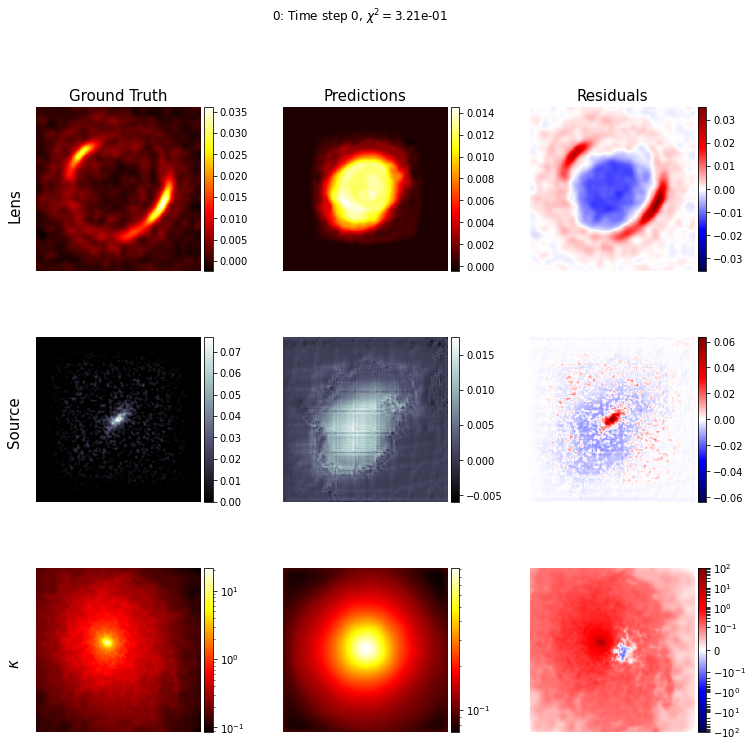

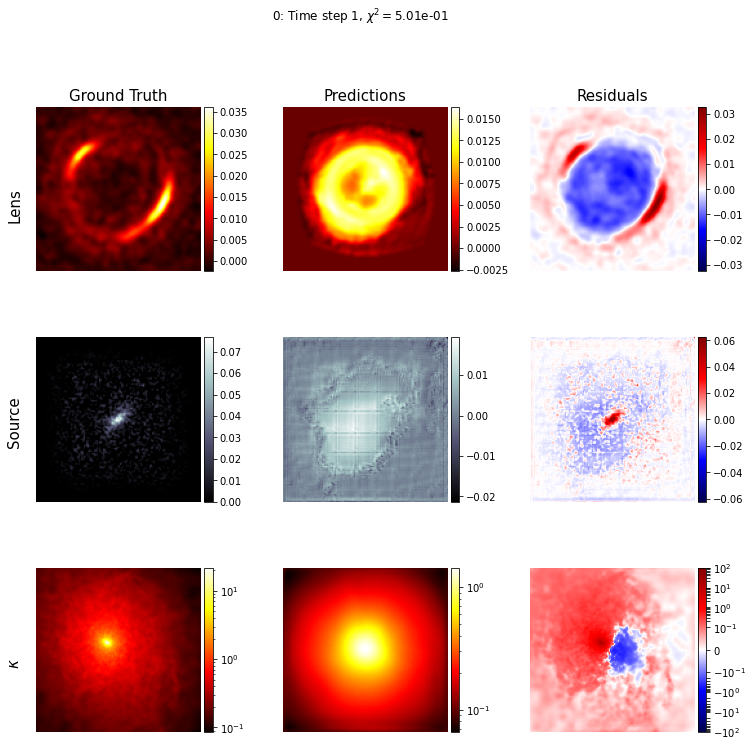

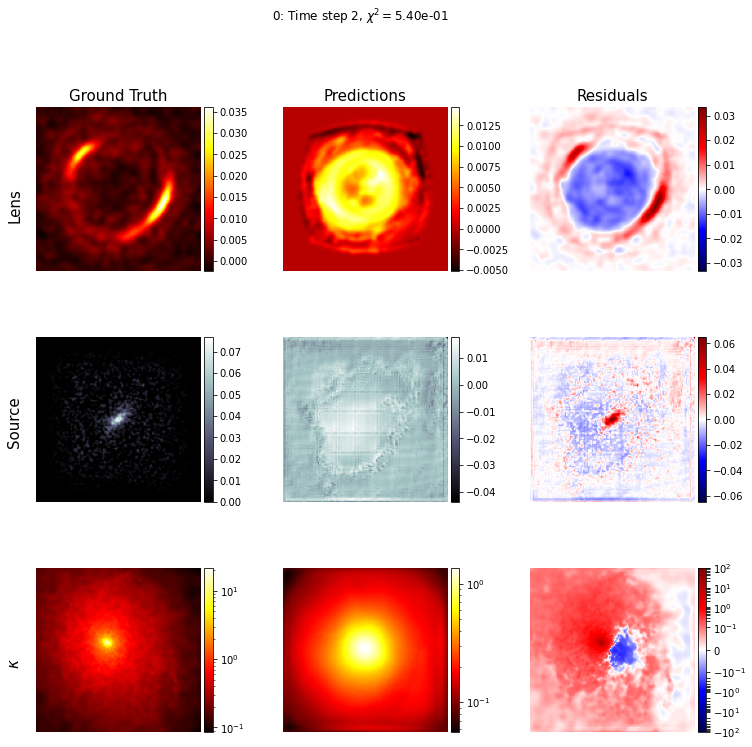

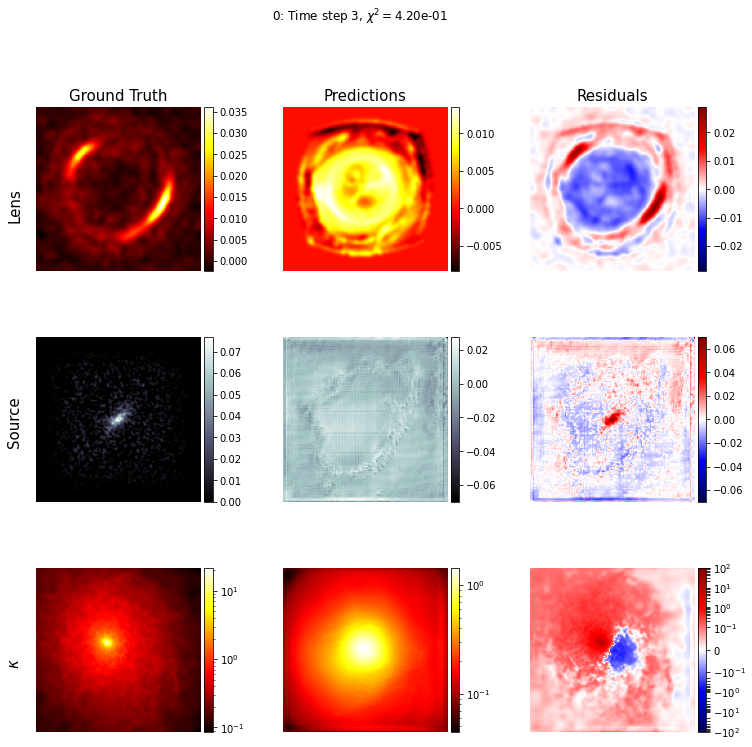

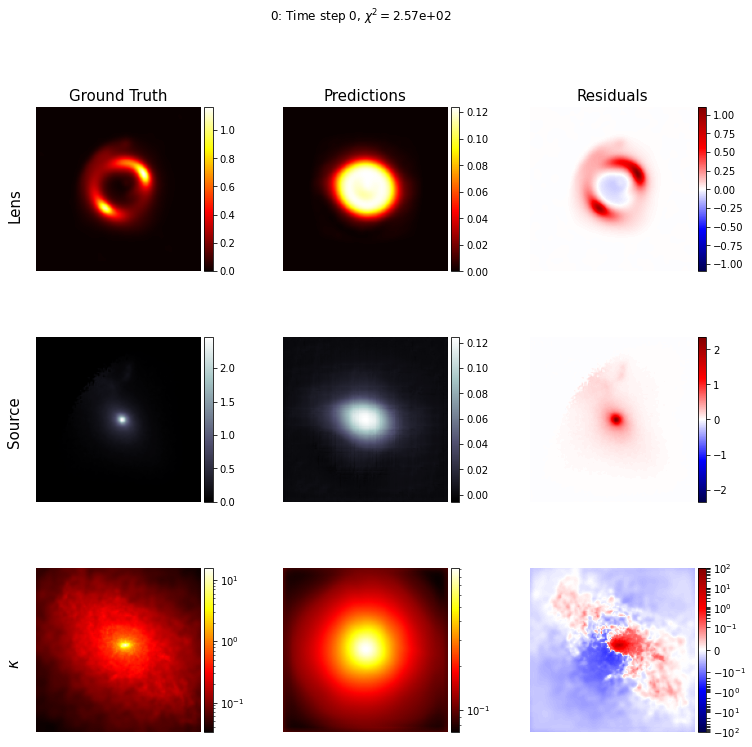

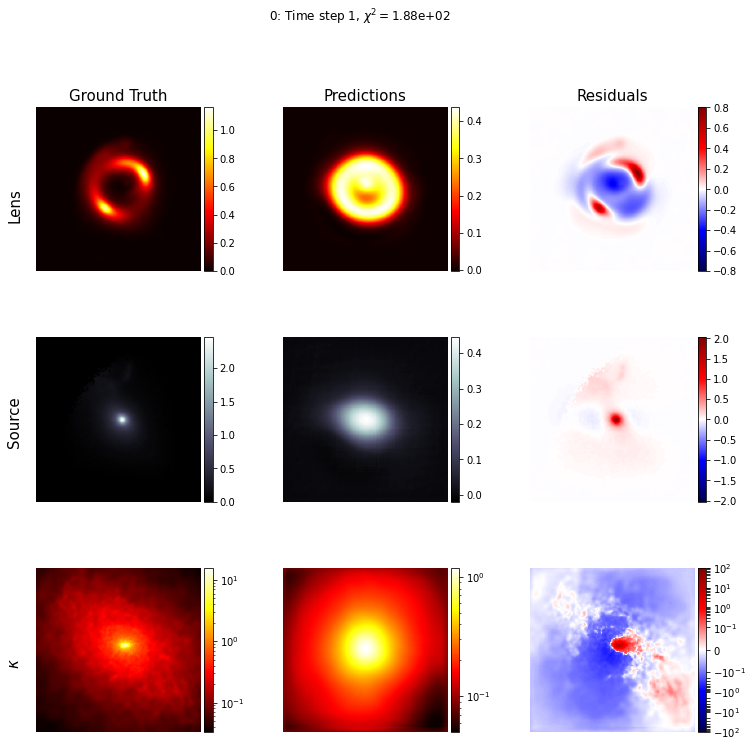

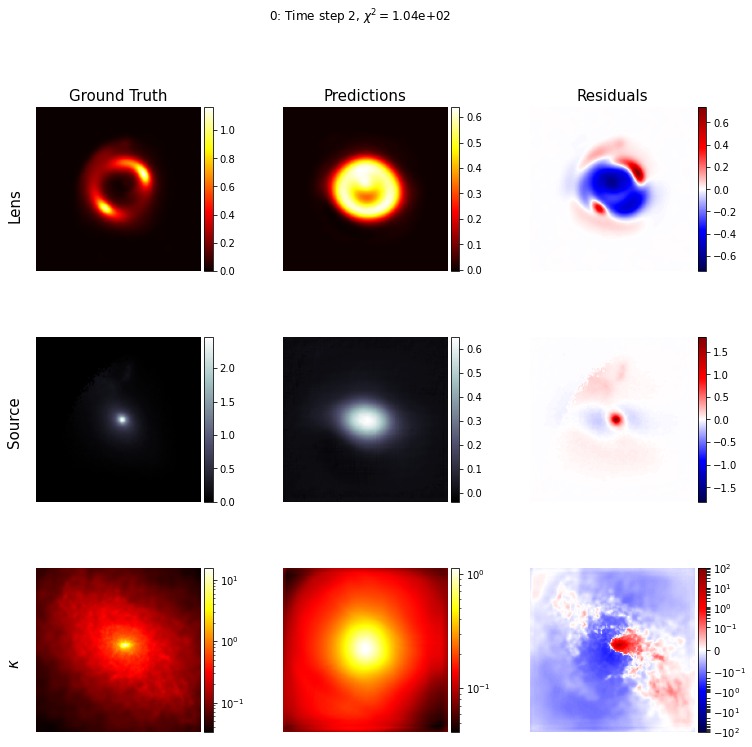

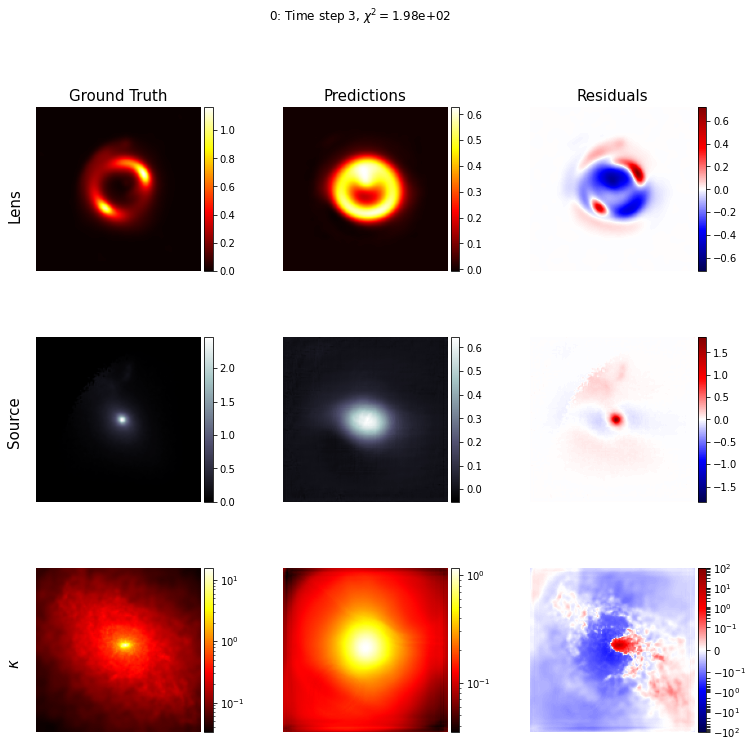

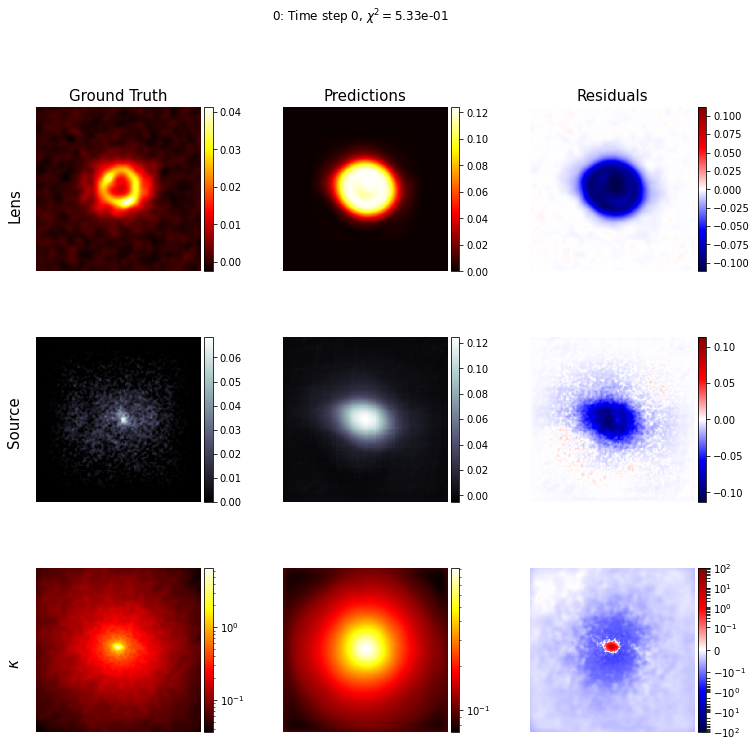

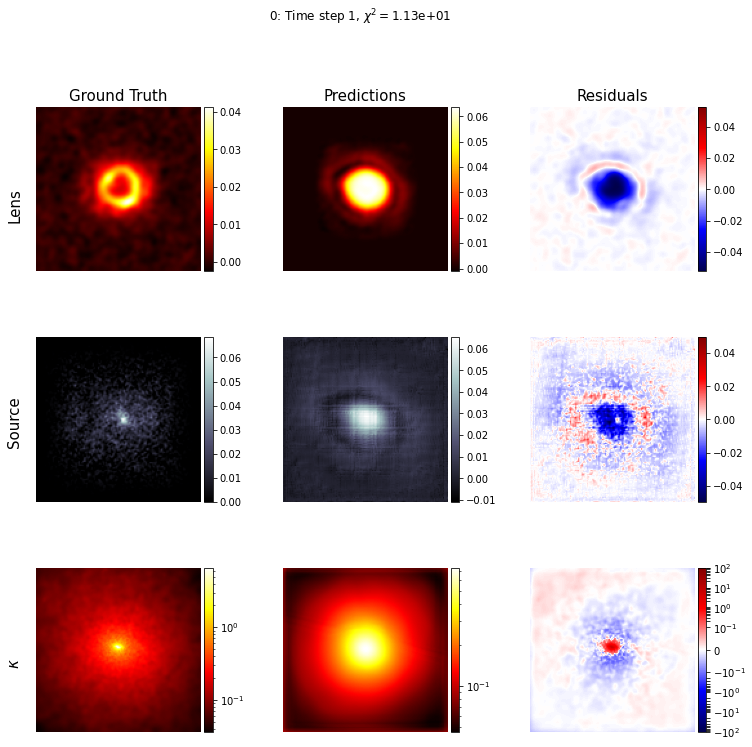

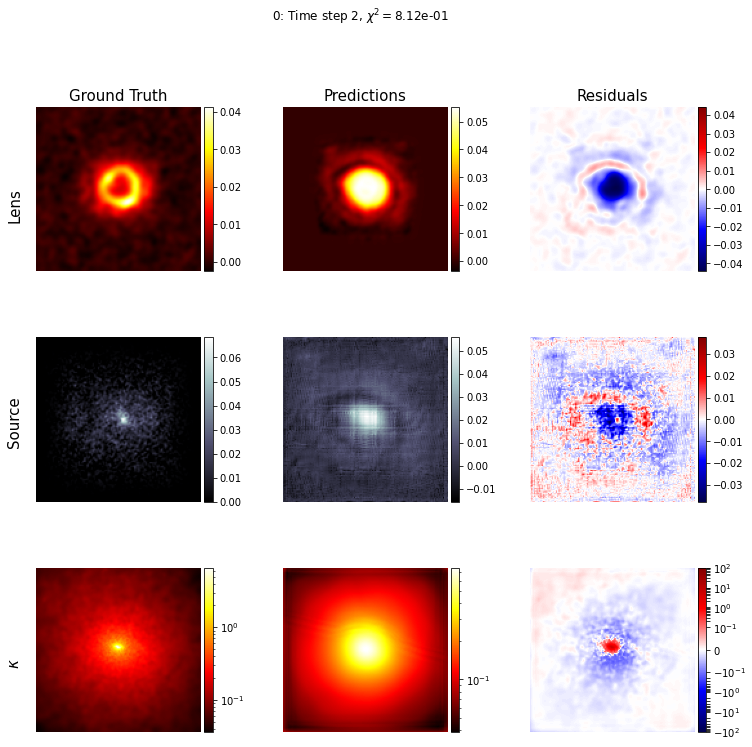

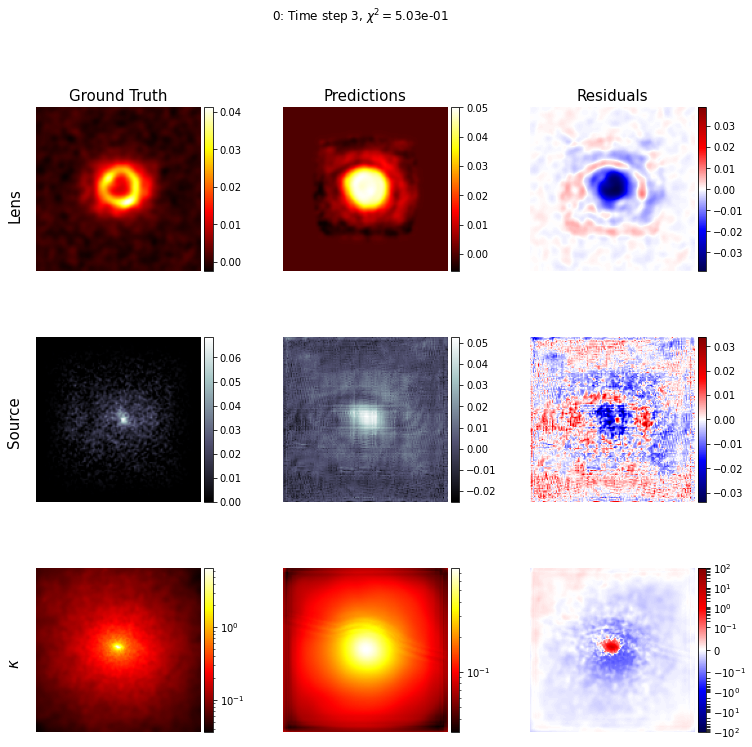

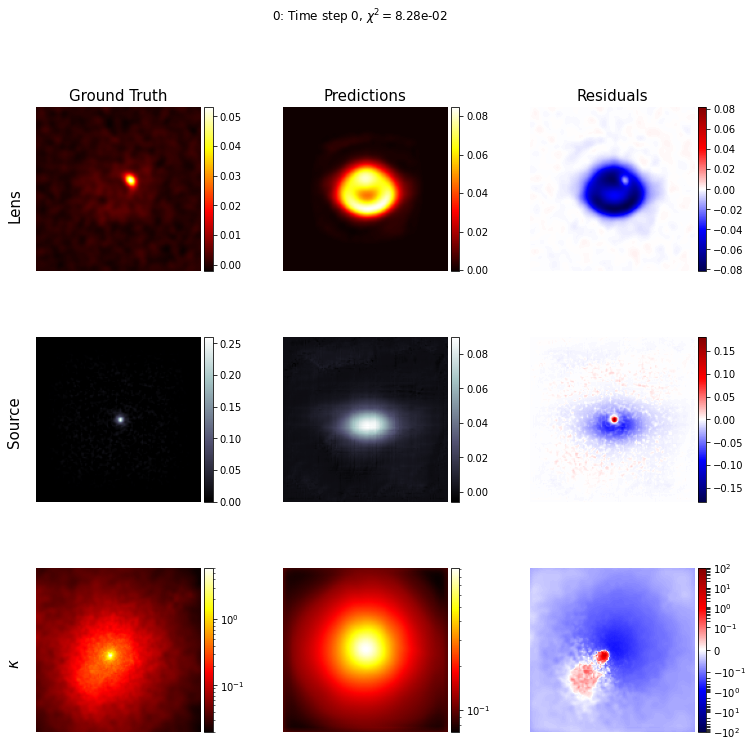

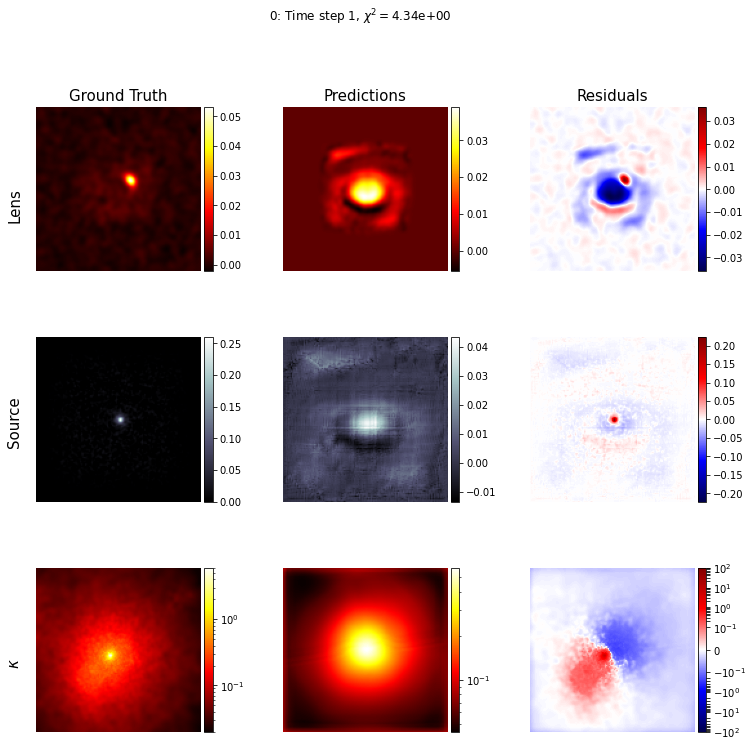

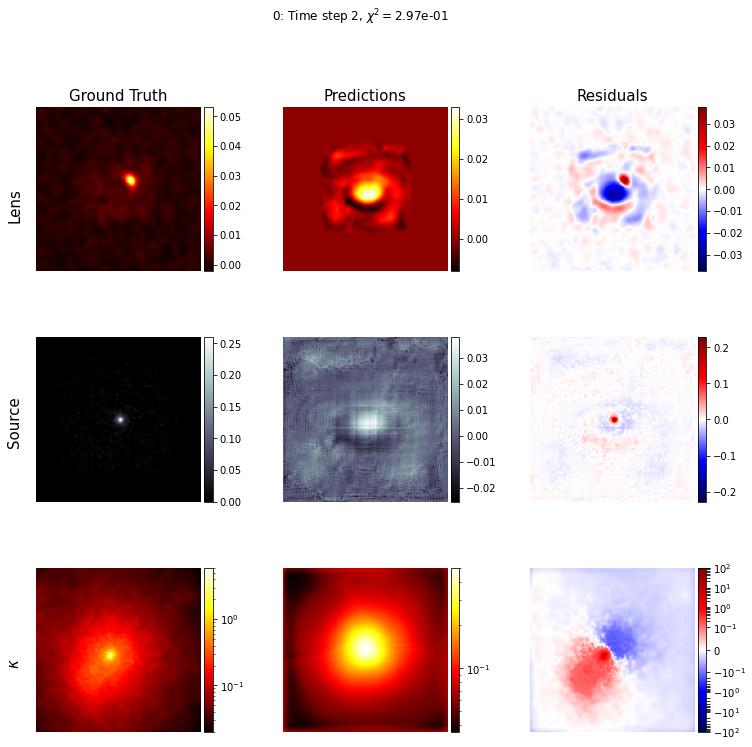

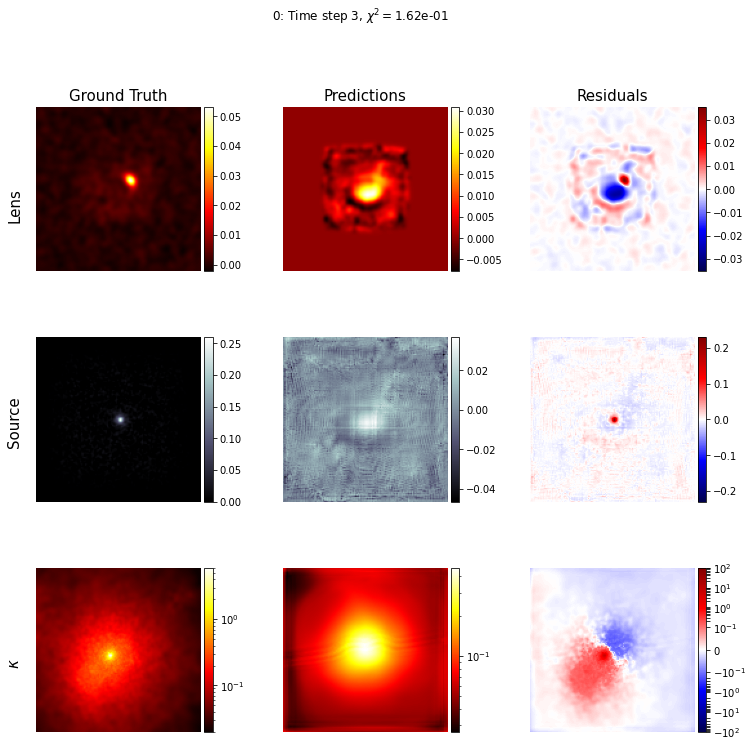

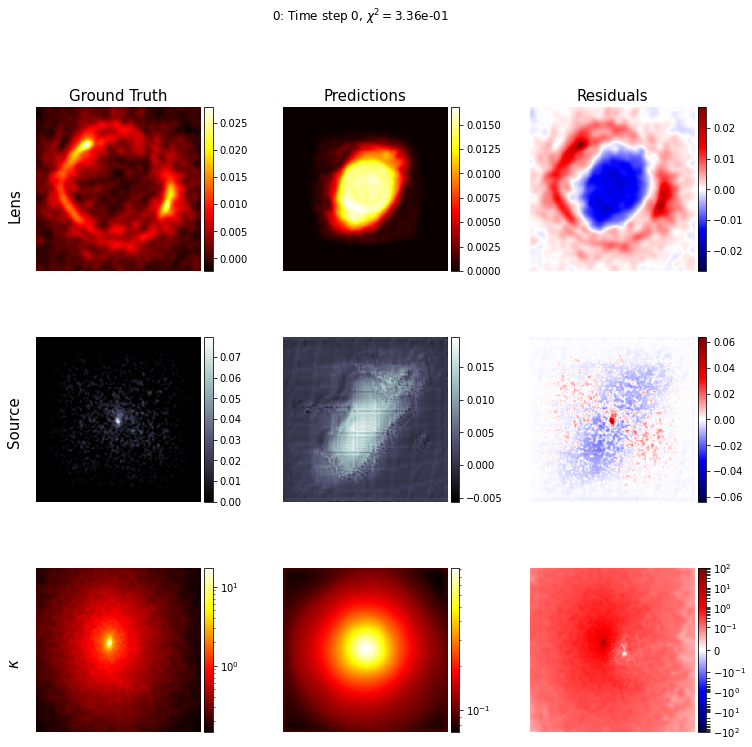

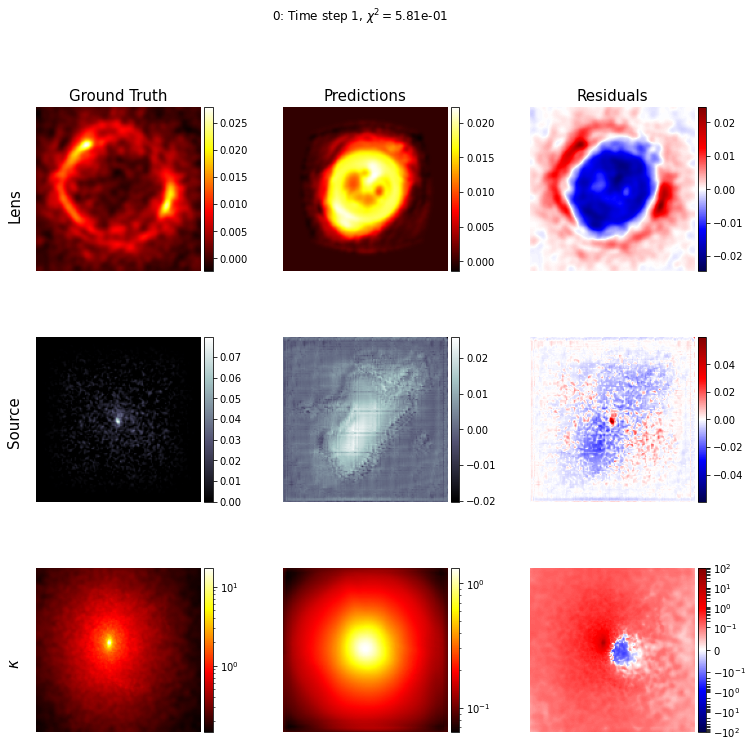

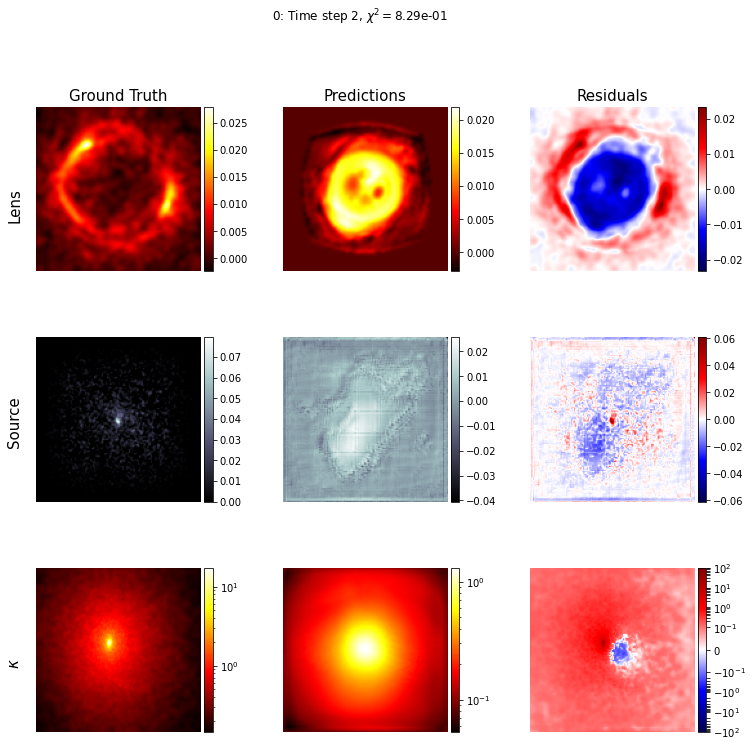

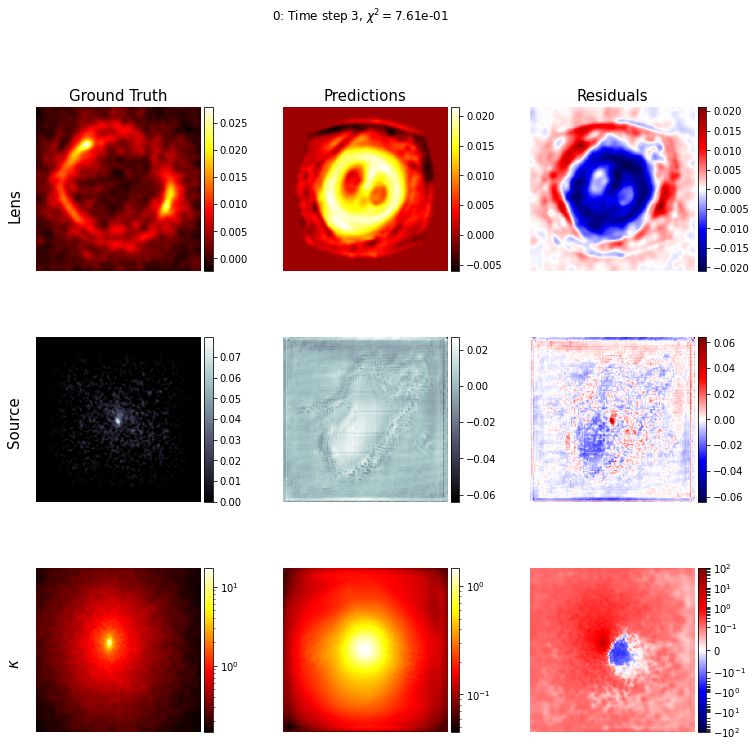

In [5]:
b = 0
for batch, distributed_inputs in enumerate(train_dataset):
    if batch == b:
        for res_idx in range(args.batch_size):
            for t in range(args.steps):
                lens_true = distributed_inputs[0][res_idx, ...]
                source_true = distributed_inputs[1][res_idx, ...]
                kappa_true = distributed_inputs[2][res_idx, ...]
                source_pred, kappa_pred, chi_squared = rim.predict(lens_true[None, ...])
                lens_pred = phys.forward(source_pred[t], kappa_pred[t])[0, ...]
                fig = residual_plot(lens_true, source_true, kappa_true, lens_pred, source_pred[t][0, ...], kappa_pred[t][0, ...], chi_squared[t][0])
                fig.suptitle(fr"{batch}: Time step {t}, $\chi^2 = ${chi_squared[t][0]:.2e}")
        break